# Networks
The purpose of this notebook is to create a visualization of the network given our features, parameters, and sub-parameters for a logistic regression model.

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import statsmodels.api as sm
import networkx as nx
import scipy as sc
import pickle
sns.set_theme(context="notebook", font_scale=1.2)
import warnings
warnings.filterwarnings('ignore')

In [2]:
scaler = MinMaxScaler()

## Preprocessing
Using the relevant features found in `EDA.ipynb`, we perform mean value imputation and normalize each feature to be in the range $[0,1]$.

In [3]:
data = pd.read_csv("Loan_Default.csv")
data.drop(columns=["ID"], inplace=True)
data = data[['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 
             'Upfront_charges', 'property_value', 'income', 'LTV', 'Credit_Score', 'dtir1', 'Status']
]
data = data.infer_objects()
data.fillna(data.mean(), inplace=True)
feat_cols = ['loan_amount', 'rate_of_interest', 'Interest_rate_spread', 
             'Upfront_charges', 'property_value', 'income', 'LTV', 'Credit_Score', 'dtir1']
data[feat_cols] = scaler.fit_transform(data[feat_cols])
data.head()

,loan_amount,rate_of_interest,Interest_rate_spread,Upfront_charges,property_value,income,LTV,Credit_Score,dtir1,Status
0,0.028090,0.505684,0.583225,0.053750,0.006667,0.003007,0.012485,0.6450,0.714286,1
1,0.053371,0.505684,0.583225,0.053750,0.029691,0.008607,0.009167,0.1300,0.584517,1
2,0.109551,0.570000,0.548678,0.009917,0.030303,0.016385,0.010096,0.8350,0.732143,0
3,0.123596,0.531250,0.617441,0.053750,0.039394,0.020533,0.008737,0.2175,0.660714,0
4,0.191011,0.500000,0.563574,0.000000,0.045455,0.018044,0.011611,0.2550,0.607143,0


## Frequentist Parameter Estimate

Now we extract the frequentist estimate for the parameters belonging to out known features. Since we do not know anything about $\beta_0$, the intercept, we can play around with values for the mean and the variance. We assume all $\beta$'s follow a normal distribution.

In [4]:
X = data[feat_cols]
y = data['Status']
model = sm.Logit(y, X)
results = model.fit()
prior_mean = results.params
prior_var = np.diag(results.cov_params())
print('Means:',prior_mean.values)
print('Variances:', prior_var)

Optimization terminated successfully.
         Current function value: 0.554504
         Iterations 6
Means: [-1.53568940e+00 -1.65196540e-01 -2.05948843e+00 -3.09079859e-02
  6.22238489e-01 -2.05294486e+01  3.32149058e+01 -1.96002650e-02
  3.89763154e-01]
Variances: [5.29895563e-02 1.56421816e-02 1.33641765e-02 1.81531209e-02
 3.37777535e-01 1.17255145e+00 1.13936624e+01 4.26206275e-04
 1.43028258e-03]


In [5]:
params = [(0,1)]
for m,v in zip(prior_mean.values, prior_var):
    params.append([(m,v)])
params

[(0, 1),
 [(-1.5356894018028753, 0.05298955627987003)],
 [(-0.1651965403208456, 0.01564218161691876)],
 [(-2.0594884325578597, 0.0133641765092344)],
 [(-0.03090798594652215, 0.018153120865576227)],
 [(0.6222384888572042, 0.3377775347927135)],
 [(-20.52944861465043, 1.1725514547879035)],
 [(33.21490575181182, 11.393662421052529)],
 [(-0.019600264999902507, 0.0004262062754423966)],
 [(0.38976315442921805, 0.0014302825837924792)]]

In [6]:
# with open('prior_params.pkl', 'wb') as f:
#     pickle.dump(params, f)

## Network Visualization

We now construct a network for all of our parameters. Since the sub-parameters for each $\beta$ vary, each $\beta$ will have it's own $\mu$ and $\sigma^2$.

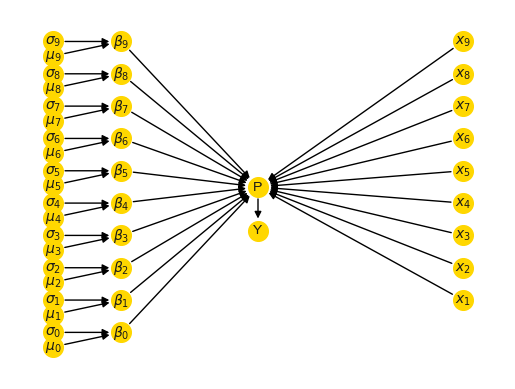

In [9]:
nodes = ['Y', 'P']
for i in range(1,10):
    nodes.append(rf'$x_{i}$')

edges = [('P', 'Y'),(r'$x_1$', 'P'), (r'$x_2$', 'P'), (r'$x_3$', 'P'), (r'$x_4$', 'P'), (r'$x_5$', 'P'), (r'$x_6$', 'P'), 
         (r'$x_7$', 'P'), (r'$x_8$', 'P'), (r'$x_9$', 'P'),
         (r'$\beta_0$', 'P'), (r'$\beta_1$', 'P'), (r'$\beta_2$', 'P'), (r'$\beta_3$', 'P'), 
         (r'$\beta_4$', 'P'), (r'$\beta_5$', 'P'), (r'$\beta_6$', 'P'), (r'$\beta_7$', 'P'), 
         (r'$\beta_8$', 'P'), (r'$\beta_9$', 'P')]
for i in range(10):
    nodes.append(rf'$\beta_{i}$')
    nodes.append(rf'$\mu_{i}$')
    nodes.append(rf'$\sigma_{i}$')
    edges += [(rf'$\beta_{i}$', 'P'), (rf'$\mu_{i}$', rf'$\beta_{i}$'), (rf'$\sigma_{i}$',rf'$\beta_{i}$')]

# Create the graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Plot the graph
pos = {}
x_pos = np.linspace(-20,20,10)
b_pos = np.linspace(-100,100,10)
for i in range(1,10):
    pos[rf'$x_{i}$'] = (45, b_pos[i])
for i in range(10):
    pos[rf'$\beta_{i}$'] = (-30, b_pos[i])
    pos[rf'$\mu_{i}$'] = (-45, b_pos[i]-10)
    pos[rf'$\sigma_{i}$'] = (-45, b_pos[i])
pos['P'] = (0,0)
pos['Y'] = (0, -30)
nx.draw_networkx_nodes(G, pos, node_color='gold', node_size=200)
nx.draw_networkx_edges(G, pos, edge_color='black')
nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')
plt.axis('off')
plt.show()
